<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/4%265_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap


In [ ]:
"""
Lecture 4.1: Introduction to Convolutional Neural Networks (CNNs)
==================================================================
This script transitions from Multilayer Perceptrons (MLPs) to Convolutional
Neural Networks (CNNs). It focuses on the motivation for CNNs, explains their
core components (Channels, Padding, Strides, Pooling) using analogies and demos,
and compares their performance, learned features, and robustness against the
AdvancedMLP from the previous lecture.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
# nn = appliances (with knobs & memory), F = recipes (just do the math).
# Use modules for weights/state; use F for simple, stateless ops.
# Great inside custom Modules when you want fine-grained control.
# Activation: nn.ReLU() ↔︎ F.relu(x)
# Pooling: nn.MaxPool2d(2) ↔︎ F.max_pool2d(x, 2)
# Loss: nn.CrossEntropyLoss() ↔︎ F.cross_entropy(logits, y)
import torch.optim as optim
from torch.utils.data import DataLoader, random_split # Import random_split here
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import math

# =========================================================================
# 0. Setup, Data Loading, and Utilities (Reused and Enhanced from Lecture 3.3)
# =========================================================================

# --- Configuration ---
SEED = 42
torch.manual_seed(SEED)
# GPUs are crucial for training CNNs due to the high number of parallel computations.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# FashionMNIST Class Names (Useful for interpretation)
CLASSES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

# --- Data Loaders ---
# We continue using normalization as it stabilizes training.
FMNIST_MEAN, FMNIST_STD = (0.2860,), (0.3530,)
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD)
])

def get_loaders(batch_train=64, batch_val=256, batch_test=256, val_size=10_000, seed=SEED):
    """Return train/val from train split, plus a held-out test set (never used during tuning)."""
    full_train = datasets.FashionMNIST("./data", train=True,  download=True, transform=TRANSFORM)
    test_ds    = datasets.FashionMNIST("./data", train=False, download=True, transform=TRANSFORM)

    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(
        full_train, [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_val,   shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_test,  shuffle=False)
    return train_loader, val_loader, test_loader

# --- Training & Evaluation Logic (Reused from Lecture 3.3) ---

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct, total_n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        # NOTE: Input 'x' is (B, C, H, W). The model handles flattening internally if needed.

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
    return total_loss / total_n, total_correct / total_n


# =============================================================================
# 1. The Motivation: Revisiting the MLP
# =============================================================================

# We start by reloading the AdvancedMLP architecture from the last lecture.
# This serves as our strong baseline.

class AdvancedMLP(nn.Module):
    # (Using the exact definition from the previous lecture)
    def __init__(self, input_dim=28*28, hidden_dims=(128, 128, 128), output_dim=10,
                 activation="relu", init_method="he", norm_type="none", dropout_rate=0.0):
        super().__init__()
        activations = {
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU(0.1),
        }

        def _get_activation(name):
          return activations.get(name, nn.ReLU())

        self.activation = _get_activation(activation)
        dims = [input_dim, *hidden_dims, output_dim]

        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.drops = nn.ModuleList()

        for i in range(len(dims) - 2):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
            self.norms.append(self._make_norm(dims[i+1], norm_type))
            self.drops.append(nn.Dropout(dropout_rate))

        self.layers.append(nn.Linear(dims[-2], dims[-1]))
        self._init_weights(init_method)

    def _make_norm(self, num_features, kind):
        if kind == "batch": return nn.BatchNorm1d(num_features)
        if kind == "layer": return nn.LayerNorm(num_features)
        return nn.Identity()

    def _init_weights(self, method):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if method == "he":
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # THE FATAL FLAW (Lecture PDF, Page 1-2):
        if x.dim() > 2:
            # Flattening the image (28x28 -> 784) destroys all spatial information.
            x = x.view(x.size(0), -1)

        # The MLP treats the image as a disorganized "bag of pixels". (PDF Page 2, Fig 1).
        # This makes it inefficient (no weight sharing) and brittle to translations.

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.norms[i](x)
            x = self.activation(x)
            x = self.drops[i](x)

        return self.layers[-1](x)

Using device: cuda


# CNN 1

>>> Running Demos...

--- Demo 2.1: Visualizing Hand-crafted Kernels ---


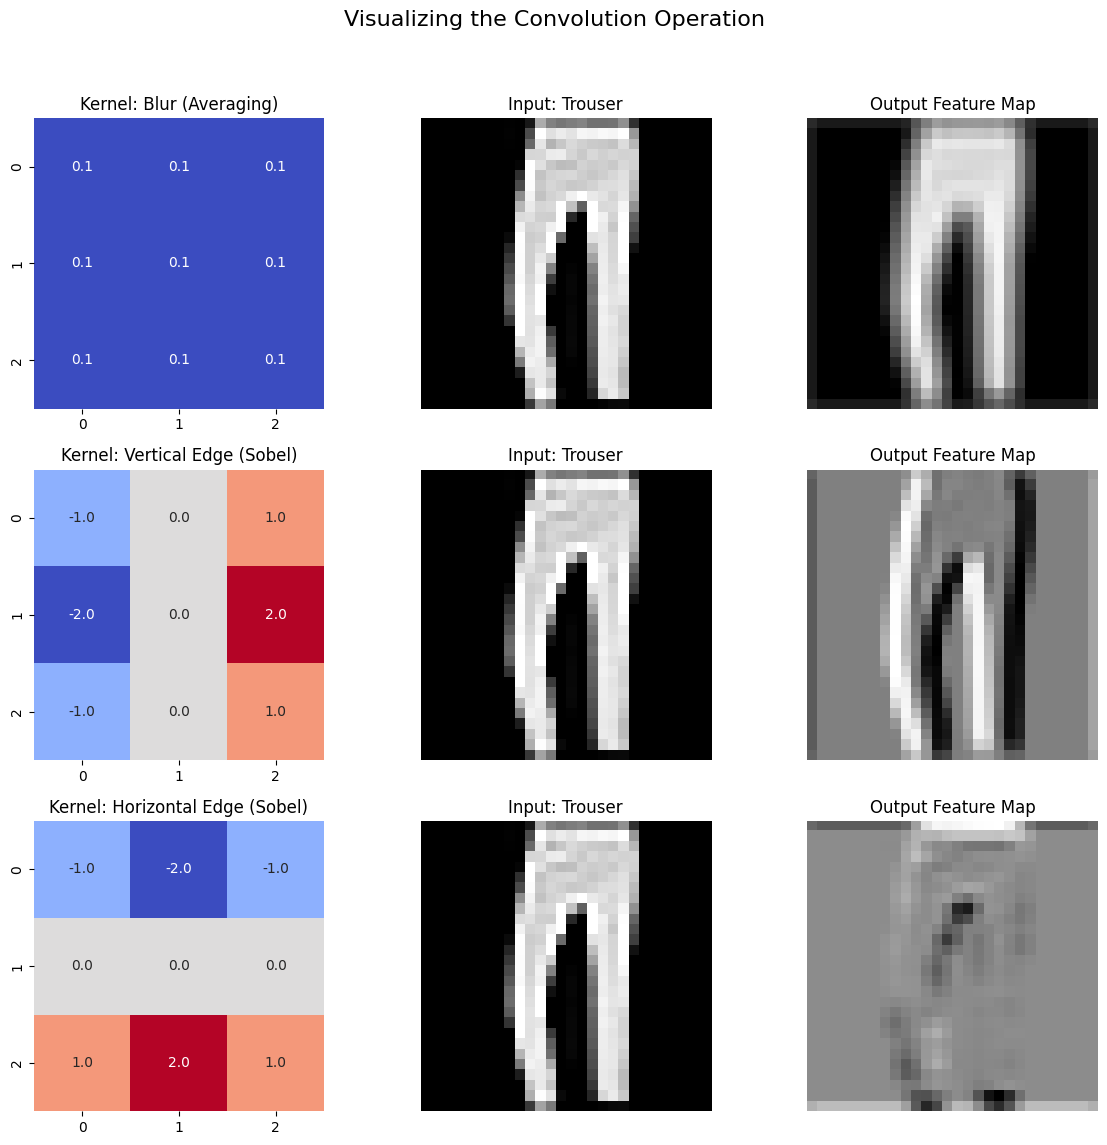


--- Demo 3.1: Padding & Stride (Shape Math) ---
Input shape: torch.Size([1, 1, 8, 8])
K=3, P=0, S=1 -> torch.Size([1, 1, 6, 6]) (Shrinks)
K=3, P=1, S=1 -> torch.Size([1, 1, 8, 8]) (Keeps size)
K=3, P=1, S=2 -> torch.Size([1, 1, 4, 4]) (Downsamples)

--- Demo 3.2: Pooling (Summarization and Invariance) ---
Input:
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])

MaxPool (K=2, S=2):
 tensor([[ 5.,  7.],
        [13., 15.]])

AvgPool (K=2, S=2):
 tensor([[ 2.5000,  4.5000],
        [10.5000, 12.5000]])

--- Demo 4.1: Channels (Multi-In/Multi-Out) ---
Scenario 1: 1 Input Channel -> 6 Output Channels
Input: torch.Size([1, 1, 28, 28]) -> Output: torch.Size([1, 6, 28, 28])
Kernel Weights Shape: torch.Size([6, 1, 5, 5])
We have 6 independent kernels, each looking at the 1 input channel.

Scenario 2: 6 Input Channels -> 16 Output Channels (Cross-Talk)
Input: torch.Size([1, 6, 28, 28]) -> Output: torch.Size([1, 16, 28, 28]

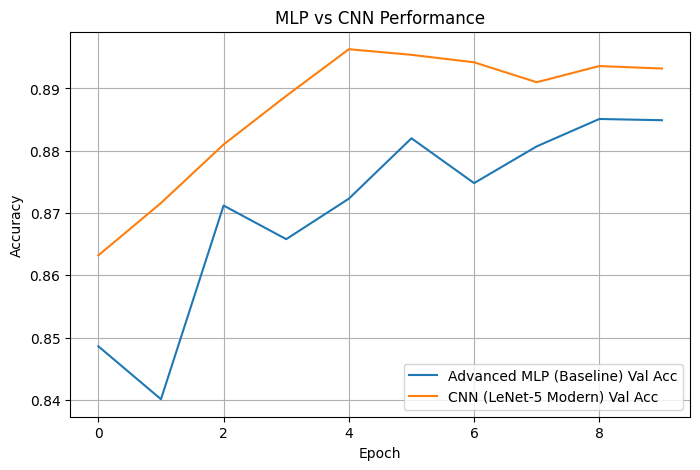


--- Analysis 2: Visualizing Learned Features (What they look for) ---


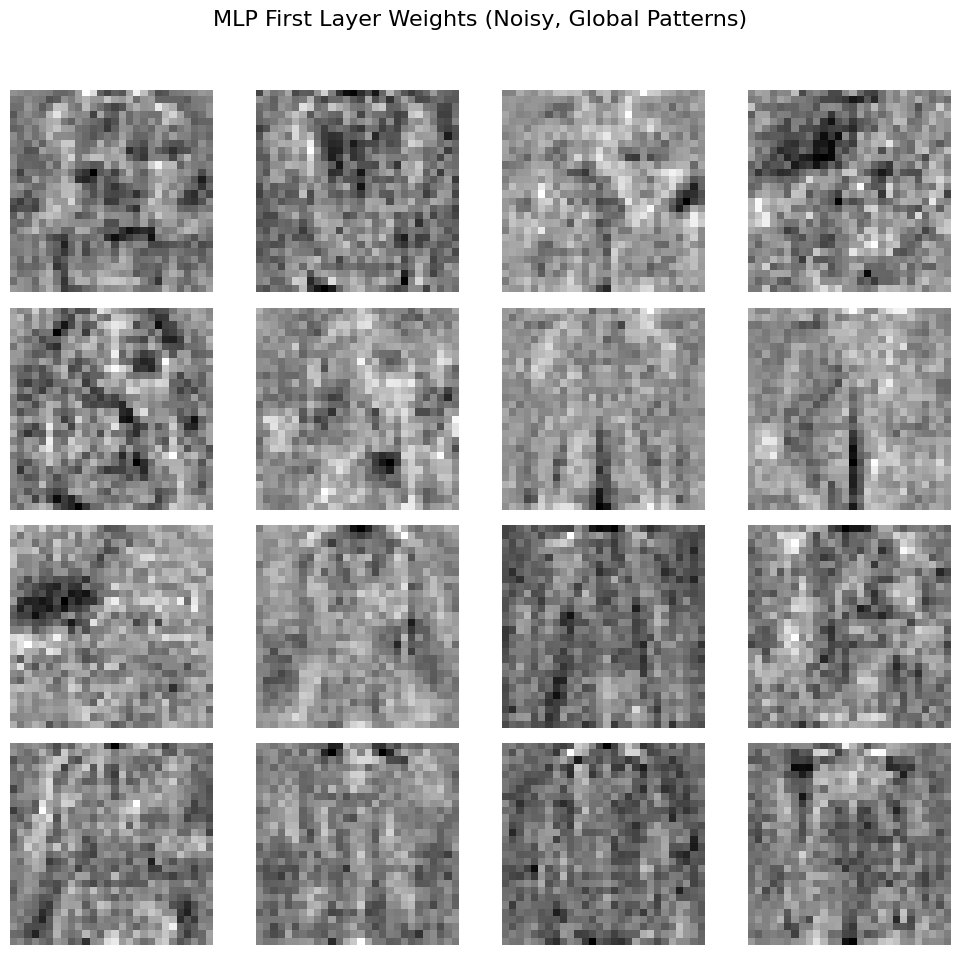

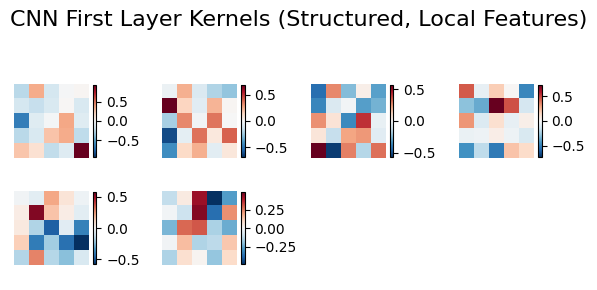


--- Analysis 3: Visualizing Feature Maps (Where they fired) ---


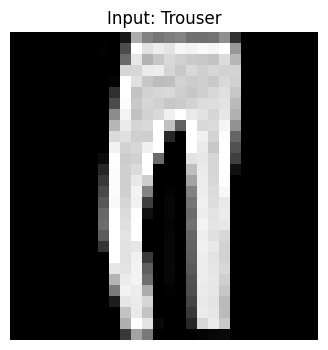

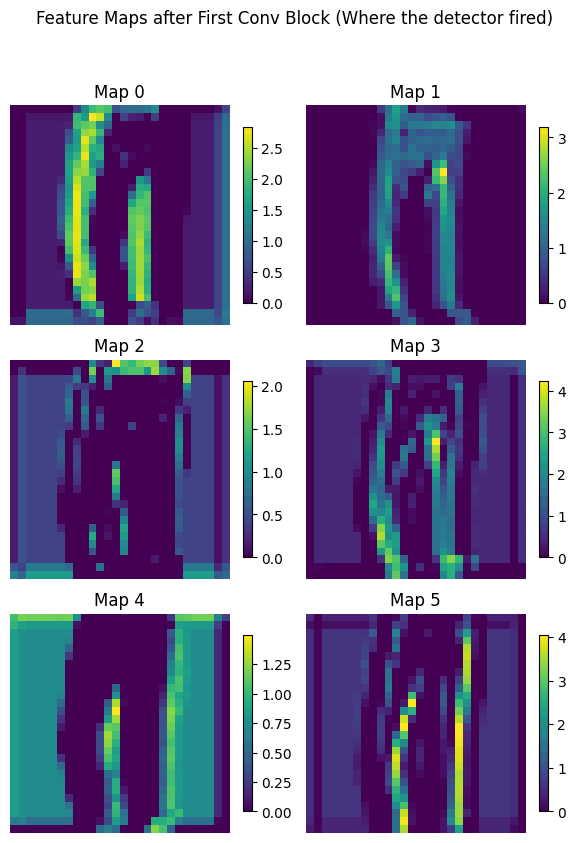


--- Analysis 4: Translation Test (Robustness to Shifts) ---

Testing AdvancedMLP robustness to 3px shift:


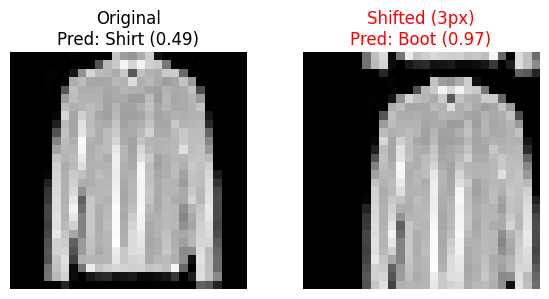

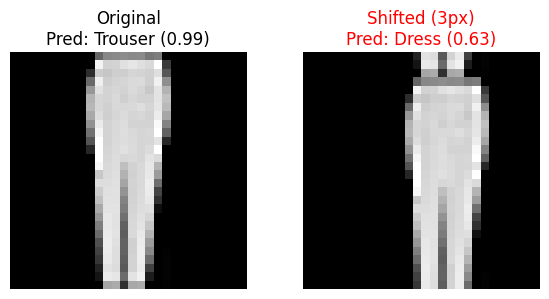

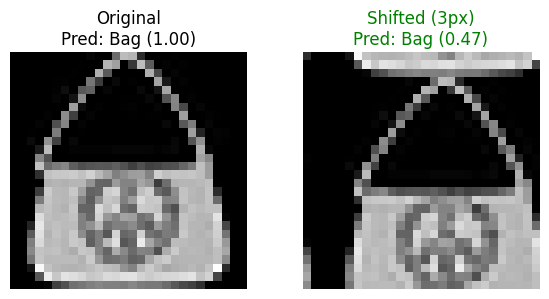


Testing LeNet5Modern robustness to 3px shift:


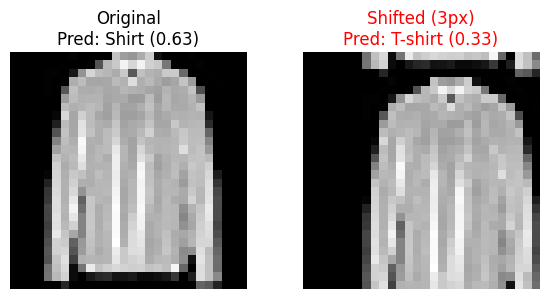

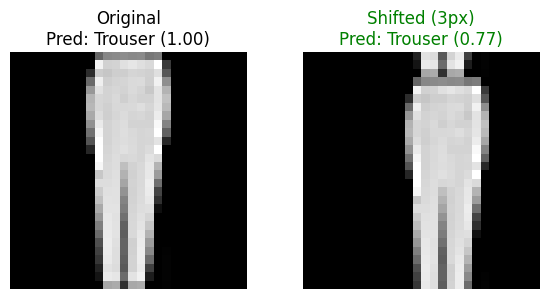

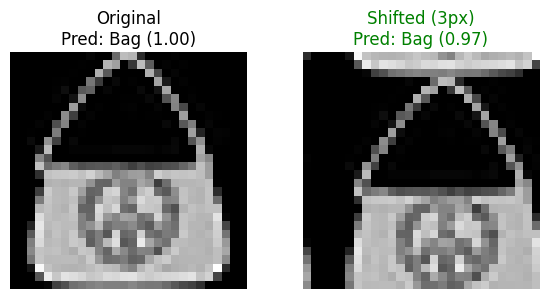

In [ ]:
# =============================================================================
# 2. The Core Idea: The Convolution Operation
# =============================================================================

"""
The Sliding Window

To fix the MLP's flaws, we introduce an architecture with Spatial Inductive Bias:
1. Locality: Patterns are local.
2. Translation Equivariance: A pattern is the same regardless of where it is.

The Convolution operation provides this bias.

Analogy: The Feature Detective (Kernel/Filter)
Imagine a small magnifying glass (the Kernel) specialized in detecting one specific
pattern. We slide this magnifying glass across the image. The SAME weights are used
everywhere (Parameter Sharing).
"""

# --- DEMO: Visualizing Convolution with Predefined Kernels ---

def demo_handcrafted_kernels(data_loader, image_index=7):
    """
    Demonstrates how different kernels extract different features,
    before we start learning them. (PDF Page 4-5).
    """
    print("\n--- Demo 2.1: Visualizing Hand-crafted Kernels ---")

    # Get a sample image (Index 7 is often an Ankle boot)
    sample_image, label = data_loader.dataset[image_index]

    # EXPLANATION: Reversing Normalization for Visualization
    # The image was normalized during loading: normalized = (original - mean) / std
    # To reverse this for display: original = (normalized * std) + mean
    # This brings pixel values back to [0, 1] range for proper visualization
    image_np = (sample_image * FMNIST_STD[0] + FMNIST_MEAN[0]).squeeze().cpu().numpy()

    # EXPLANATION: Preparing tensor for convolution
    # unsqueeze(0) adds batch dimension: (C, H, W) -> (1, C, H, W)
    # PyTorch conv2d expects 4D input: (Batch, Channels, Height, Width)
    image_t = sample_image.unsqueeze(0).to(DEVICE) # Shape (1, 1, 28, 28)

    # Define classic computer vision kernels
    kernels = {
        "Blur (Averaging)": torch.tensor([[1/9]*3]*3, dtype=torch.float32),
        # Sobel filters detect edges by looking for sharp changes in intensity
        "Vertical Edge (Sobel)": torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32),
        "Horizontal Edge (Sobel)": torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32),
    }

    fig, axs = plt.subplots(len(kernels), 3, figsize=(12, 4 * len(kernels)))
    fig.suptitle("Visualizing the Convolution Operation", fontsize=16)

    for i, (name, kernel) in enumerate(kernels.items()):
        # Prepare kernel for PyTorch (Out_C, In_C, K_H, K_W)
        kernel_t = kernel.unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Apply the convolution using F.conv2d (the low-level function)
        with torch.no_grad():
            # Use padding=1 to keep the output size the same (for 3x3 kernel)
            output_t = F.conv2d(image_t, kernel_t, padding=1)

        output_np = output_t.squeeze().cpu().numpy()

        # 1. Show the Kernel (The stencil/magnifying glass)
        sns.heatmap(kernel.numpy(), annot=True, cmap='coolwarm', ax=axs[i, 0], cbar=False, square=True, fmt='.1f')
        axs[i, 0].set_title(f"Kernel: {name}")

        # 2. Show the Input Image
        axs[i, 1].imshow(image_np, cmap='gray')
        axs[i, 1].set_title(f"Input: {CLASSES[label]}")
        axs[i, 1].axis('off')

        # 3. Show the Output (Feature Map)
        # Notice how the edge detectors highlight changes and ignore flat areas.
        axs[i, 2].imshow(output_np, cmap='gray')
        axs[i, 2].set_title("Output Feature Map")
        axs[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# TO RUN THIS DEMO IMMEDIATELY, UNCOMMENT:
# train_loader, val_loader, test_loader = get_loaders()
# demo_handcrafted_kernels(val_loader, image_index=7)

# =============================================================================
# 3. CNN Building Blocks: Padding, Strides, and Pooling
# =============================================================================
# Let's explore the knobs we use to control the shape of the output.

@torch.no_grad()
def demo_padding_stride():
    """Demonstrates how padding and stride affect output shape. (PDF Pg 7-8)"""
    print("\n--- Demo 3.1: Padding & Stride (Shape Math) ---")
    # Create a simple 8x8 input (Batch=1, Channel=1, H=8, W=8)
    X = torch.randn(1, 1, 8, 8)
    print(f"Input shape: {X.shape}")

    # 1. Default (K=3, P=0, S=1)
    conv_no_pad = nn.Conv2d(1, 1, kernel_size=3, padding=0, stride=1)
    # Output Formula: floor( (Input + 2*P - K)/S + 1 ) The last index that can take another K: Input + 2*P - K
    # Output: (8 + 0 - 3)/1 + 1 = 6x6.
    print(f"K=3, P=0, S=1 -> {conv_no_pad(X).shape} (Shrinks)")
    # LECTURE NOTE: It shrinks because the kernel can't center on the edge pixels. (PDF Fig 6).

    # 2. Padding (K=3, P=1, S=1)
    # P=1 adds a border of zeros.
    # To keep the size the same when S=1, we need P = (K-1)/2. (For K=3, P=1).
    conv_with_pad = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1)
    # Output: (8 + 2*1 - 3)/1 + 1 = 8x8.
    print(f"K=3, P=1, S=1 -> {conv_with_pad(X).shape} (Keeps size)")

    # 3. Stride (K=3, P=1, S=2)
    # Stride controls the step size. S=2 means we skip every other pixel.
    conv_stride2 = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
    # Output: (8 + 2*1 - 3)/2 + 1 = 7/2 + 1 = 3.5 + 1 = 4x4 (floor).
    print(f"K=3, P=1, S=2 -> {conv_stride2(X).shape} (Downsamples)")

# TO RUN THIS DEMO IMMEDIATELY, UNCOMMENT:
# demo_padding_stride()

@torch.no_grad()
def demo_pooling():
    """Demonstrates Pooling operations using a deterministic input. """
    print("\n--- Demo 3.2: Pooling (Summarization and Invariance) ---")

    # Create a deterministic 4x4 input (inspired by the provided snippet)
    X = torch.arange(16, dtype=torch.float32).reshape(1, 1, 4, 4)
    print("Input:\n", X[0,0])

    """
    Why Pooling?
    Convolutions are Equivariant (the feature map shifts if the input shifts).
    Classification needs Invariance (we care IF a feature is present, not exactly where).
    Pooling summarizes a neighborhood, making the network less sensitive to exact location.
    """

    # Max Pooling: "What is the strongest clue in this neighborhood?"
    # Common usage: K=2, S=2 (halves the dimensions, non-overlapping)
    max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    # Look at the top-left 2x2 block: [[0, 1], [4, 5]]. The max is 5.
    print("\nMaxPool (K=2, S=2):\n", max_pool(X)[0,0])

    # Average Pooling: "What is the general vibe of this neighborhood?"
    avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
    # POINT: The average of the top-left block: (0+1+4+5)/4 = 10/4 = 2.5.
    print("\nAvgPool (K=2, S=2):\n", avg_pool(X)[0,0])

    # LECTURE NOTE: MaxPool is generally preferred as it preserves the strongest features.

# TO RUN THIS DEMO IMMEDIATELY, UNCOMMENT:
# demo_pooling()

# =============================================================================
# 4. Understanding Channels (The Depth Dimension)
# =============================================================================

"""
 Channels (Depth Dimension) (PDF Pg 9)

This is often the most confusing part of CNNs. Let's clarify how channels work.

Analogy: The Team of Specialized Detectives

--- 1. Going from 1 Input Channel to N Output Channels (e.g., Grayscale 1 -> 6) ---

Q: We have a grayscale image (1 channel). What does it mean to have 6 output channels?
A: It means we are creating 6 independent kernels (filters).
   It's like hiring a team of 6 detectives. Each detective looks at the *same* input image
   but learns to detect a DIFFERENT pattern (e.g., one for vertical edges, one for corners).

Q: Is this similar to Attention Heads?
A: Yes, conceptually it is! In Transformers, multiple heads allow the model to focus on
   different relationships in the sequence. In CNNs, multiple output channels allow the
   model to detect different visual features simultaneously in the same location.

Output: A stack of 6 feature maps (one report from each detective).

--- 2. Going from N Input Channels to M Output Channels (e.g., 6 -> 16) ---

Now the input is the stack of 6 feature maps from the previous layer.
The kernels must also match this depth! A kernel for this layer isn't just a 5x5 grid;
it's a 5x5x6 volume (a 3D kernel).

Q: How does the "Channel Cross-Talk" work?
A: When this 3D kernel slides over a patch of the input (which is also 5x5x6),
   the convolution happens spatially (5x5) AND across the depth (6).

CRITICAL POINT: The results across all input channels are SUMMED together (+ bias)
to produce a SINGLE value in the output feature map.

Analogy: The Senior Detective
A senior detective (the 3D kernel) combines the findings of the 6 junior detectives.
They learn weights that might mean: "If Detective #1 reported a vertical edge AND
Detective #2 reported a horizontal edge right here, then I have found a 'corner'."

This interaction (summing across C_in) is the "cross-talk" and is how CNNs build
hierarchical, complex features from simple ones.
"""

@torch.no_grad()
def demo_channels():
    print("\n--- Demo 4.1: Channels (Multi-In/Multi-Out) ---")

    # Scenario 1: Grayscale to Features (1 -> 6)
    print("Scenario 1: 1 Input Channel -> 6 Output Channels")
    X_gray = torch.randn(1, 1, 28, 28) # (B, C_in, H, W)
    conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
    Y1 = conv1(X_gray)
    print(f"Input: {X_gray.shape} -> Output: {Y1.shape}")
    # Weight shape: (C_out, C_in, K_h, K_w)
    print(f"Kernel Weights Shape: {conv1.weight.shape}") # (6, 1, 5, 5)
    print("We have 6 independent kernels, each looking at the 1 input channel.")

    # Scenario 2: Features to Higher Features (6 -> 16)
    print("\nScenario 2: 6 Input Channels -> 16 Output Channels (Cross-Talk)")
    X_feat = Y1 # Input has 6 channels
    conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
    Y2 = conv2(X_feat)
    print(f"Input: {X_feat.shape} -> Output: {Y2.shape}")
    print(f"Kernel Weights Shape: {conv2.weight.shape}") # (16, 6, 5, 5)
    print("We have 16 independent kernels. Each kernel is 3D (5x5x6) and looks across ALL 6 input channels.")

# TO RUN THIS DEMO IMMEDIATELY, UNCOMMENT:
# demo_channels()

# =============================================================================
# 5. Building a CNN: LeNet-5 (Modernized)
# =============================================================================

"""
Putting it all together

We will implement a modernized version of the pioneering LeNet-5 (PDF Pg 14).
Architecture: [CONV -> BN -> RELU -> POOL] x2 -> [FLATTEN -> FC x3]
"""

class LeNet5Modern(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # === Feature Extractor (Convolutional Base) ===

        # --- Block 1: From Pixels to Basic Features ---
        # Input: (B, 1, 28, 28). Grayscale image.

        # Configuration Explanation
        # Input Channels: 1 (Grayscale)
        # Output Channels: 6. We want to learn 6 basic features (like 6 specialized detectives/attention heads).
        # Kernel Size (K): 5x5.
        # Padding (P): 2.
        # Why P=2? We want the output HxW to remain 28x28.
        # The formula for 'same' padding (when Stride=1) is P = (K-1)/2.
        # P = (5-1)/2 = 2.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)

        # BatchNorm2d: Normalizes spatial data across B, H, W for each of the 6 channels.
        self.bn1 = nn.BatchNorm2d(6)

        # Pool: Downsamples 28x28 to 14x14. Reduces computation and builds invariance.
        # Output: (B, 6, 14, 14)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Block 2: From Basic Features to Complex Features (Cross-Talk) ---
        # Input: (B, 6, 14, 14).

        # Configuration Explanation
        # Input Channels: 6 (The features from Block 1).
        # Output Channels: 16. We expand the feature space to detect more complex patterns.
        # Kernel Size (K): 5x5.
        # Padding (P): 0. In LeNet, padding was often omitted here, causing shrinkage.

        # How the channels interact (Cross-Talk): The kernels here are 3D (5x5x6). They look across
        # ALL 6 input channels simultaneously and SUM the results. This combines the
        # simple features from Block 1 into complex features in Block 2.

        # Output size calculation: (14 + 2*0 - 5)/1 + 1 = 10x10.
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)

        # Pool: Downsamples 10x10 to 5x5.
        # Output: (B, 16, 5, 5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # === Classifier Head (MLP) ===

        # We must calculate the input dimension for the first Linear layer.
        # The output from Block 2 was (B, 16, 5, 5).
        # Flattened size: 16 * 5 * 5 = 400.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Initialization (He initialization works well with ReLU for CNNs too)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # The standard flow in modern CNNs: Conv -> BN -> ReLU -> Pool

        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x) # Using functional API for activation
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Flatten for the MLP head
        # CRITICAL STEP: This transition happens *after* feature extraction,
        # unlike the MLP where it happened immediately.
        x = x.view(x.size(0), -1)

        # MLP Head
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# =============================================================================
# 6. Visualization and Analysis Utilities
# =============================================================================

# --- 6.1 Visualizing Kernels (What the detector looks for) ---

def visualize_model_filters(model, title="Model Filters", max_filters=16):
    """
    Visualizes the filters (weights) of the first layer (MLP or CNN).
    """
    weights = None

    # 1. Identify the first layer and extract weights
    # Handle the AdvancedMLP structure
    if hasattr(model, 'layers') and isinstance(model.layers[0], nn.Linear):
        first_layer = model.layers[0]
        w = first_layer.weight.data.cpu().numpy()
        # Reshape back to (hidden_dim, 1, 28, 28) for visualization
        weights = w.reshape(-1, 1, 28, 28)

    # Handle the CNN structure (like LeNet)
    elif hasattr(model, 'conv1') and isinstance(model.conv1, nn.Conv2d):
        first_layer = model.conv1
         # Weights shape: (out_channels, in_channels, K_h, K_w)
        weights = first_layer.weight.data.cpu().numpy()

    if weights is None:
        print(f"Could not find suitable first layer weights for {type(model).__name__}.")
        return

    # Limit the number of filters visualized
    num_filters = min(weights.shape[0], max_filters)

    # Determine grid size
    cols = 4
    rows = (num_filters + cols - 1) // cols

    # Adjust figure size based on the filter dimensions (MLP=28x28, CNN=small)
    filter_size = weights.shape[2]
    scale = 2.5 if filter_size > 10 else 1.5
    fig_size = (cols * scale, rows * scale)

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    # Handle the case where axes might not be an array (e.g. only 1 filter)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # Ensure axes can be iterated over consistently
    if axes.ndim == 1 and (rows > 1 or cols > 1):
         axes = axes.reshape(rows, cols)

    fig.suptitle(title, fontsize=16)

    # Hide axes
    for ax in axes.flat:
        ax.axis('off')

    # Plot filters
    for i in range(num_filters):
        ax = axes.flat[i]
        # Visualize the first input channel (since input is grayscale)
        img = weights[i, 0, :, :]

        # For CNNs, visualize with a diverging colormap (RdBu_r) centered at zero
        # to clearly see positive (excitatory) and negative (inhibitory) weights.
        if filter_size <= 10: # CNN
             vmax = np.abs(img).max() + 1e-12
             # Use 'nearest' interpolation to avoid blurring small kernels
             im = ax.imshow(img, cmap='RdBu_r', interpolation='nearest', vmin=-vmax, vmax=vmax)
             plt.colorbar(im, ax=ax, shrink=0.7)
        else: # MLP
            # For MLPs, gray scale is often sufficient as they look like templates
            ax.imshow(img, cmap='gray', interpolation='nearest')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 6.2 Visualizing Feature Maps (Where the detector fired) ---

@torch.no_grad()
def show_feature_maps(model, loader, image_index=0, max_maps=8):
    """
    Visualizes the activations (Feature Maps) after the first convolutional layer.
    (Inspired by the provided snippet)
    """
    model.eval()

    # Get a specific image
    x, label = loader.dataset[image_index]
    x_input = x.unsqueeze(0).to(DEVICE)

    # Forward pass through the first block of LeNet
    if not isinstance(model, LeNet5Modern):
        print("Feature map visualization currently only supports LeNet5Modern.")
        return

    # Apply Conv -> BN -> ReLU (We often look before Pooling for more detail)
    feats = model.conv1(x_input)
    feats = model.bn1(feats)
    feats = F.relu(feats)

    feats = feats.detach().cpu()  # [1, C, H, W]

    k = min(max_maps, feats.size(1))
    cols = int(math.sqrt(k)); rows = math.ceil(k/cols)

    # Show the input image first
    plt.figure(figsize=(4, 4))
    # Reverse normalization for display
    img_vis = (x_input[0].cpu() * FMNIST_STD[0] + FMNIST_MEAN[0]).squeeze()
    plt.imshow(img_vis, cmap='gray')
    plt.title(f"Input: {CLASSES[label]}")
    plt.axis('off')
    plt.show()

    # Show the feature maps
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    # Ensure axes is always a 2D array for consistent indexing
    axes = np.array(axes)
    if axes.ndim == 1 and (rows > 1 or cols > 1):
        axes = axes.reshape(rows, cols)

    for i in range(k):
        ax = axes.flat[i]
        fmap = feats[0, i]
        # Use 'viridis' or similar colormap to show activation strength
        im = ax.imshow(fmap, cmap='viridis')
        ax.set_title(f"Map {i}"); ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.7)

    plt.suptitle("Feature Maps after First Conv Block (Where the detector fired)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 6.3 Testing Translation Invariance (Robustness) ---

@torch.no_grad()
def translation_test(model, loader, n=3, shift_pixels=3):
    """
    Tests model robustness to small shifts in the input image.
    (Inspired by the provided snippet)
    """
    model.eval()

    # We use an iterator in case we need to look through multiple batches
    data_iter = iter(loader)

    print(f"\nTesting {type(model).__name__} robustness to {shift_pixels}px shift:")

    shown = 0
    while shown < n:
        try:
            x, y = next(data_iter)
        except StopIteration:
            print("Ran out of data during translation test.")
            break

        x, y = x.to(DEVICE), y.to(DEVICE)

        for i in range(len(x)):
            if shown >= n:
                break

            img = x[i:i+1]
            logits = model(img)
            pred = logits.argmax(1).item()
            conf = logits.softmax(1)[0, pred].item()

            # Shift the image using torch.roll along dims (H=2, W=3)
            img_shift = torch.roll(img, shifts=(shift_pixels, shift_pixels), dims=(2, 3))

            logits_s = model(img_shift)
            pred_s = logits_s.argmax(1).item()
            conf_s = logits_s.softmax(1)[0, pred_s].item()

            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))

            # Reverse normalization for display
            img_vis = (img[0].cpu() * FMNIST_STD[0] + FMNIST_MEAN[0]).squeeze()
            img_shift_vis = (img_shift[0].cpu() * FMNIST_STD[0] + FMNIST_MEAN[0]).squeeze()

            axes[0].imshow(img_vis, cmap='gray')
            axes[0].set_title(f"Original\nPred: {CLASSES[pred]} ({conf:.2f})")

            axes[1].imshow(img_shift_vis, cmap='gray')
            title_s = f"Shifted ({shift_pixels}px)\nPred: {CLASSES[pred_s]} ({conf_s:.2f})"

            # Highlight if the prediction changed
            if pred != pred_s:
                axes[1].set_title(title_s, color='red')
            else:
                axes[1].set_title(title_s, color='green')

            for ax in axes: ax.axis('off')
            plt.tight_layout(); plt.show()
            shown += 1


# =============================================================================
# 7. The Experiment: MLP vs CNN Comparison
# =============================================================================

def run_comparison(train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    """
    Trains both the best MLP configuration and the CNN to compare performance.
    """

    # Configuration for the best MLP found in the previous lecture (Lecture 3.3)
    mlp_config = {
        "hidden_dims": (128, 128, 128),
        "init_method": "he",
        "norm_type": "layer", # LayerNorm worked best for this MLP setup
        "dropout_rate": 0.2
    }

    configs = {
        "Advanced MLP (Baseline)": {"model_class": AdvancedMLP, "config": mlp_config},
        "CNN (LeNet-5 Modern)": {"model_class": LeNet5Modern, "config": {}},
    }

    histories = {}
    criterion = nn.CrossEntropyLoss()

    for name, setup in configs.items():
        print(f"\n>>> Training Model: {name}")
        ModelClass = setup["model_class"]
        config = setup["config"]

        model = ModelClass(**config).to(DEVICE)
        # We use Adam optimizer for both, a standard practice.
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        history = {"train_acc": [], "val_acc": []}

        # Parameter Count Comparison
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Total Parameters: {num_params:,}")

        # LECTURE_NOTE: Compare the counts!
        # Advanced MLP (~135k params) vs LeNet (~62k params).
        # The CNN uses significantly fewer parameters due to WEIGHT SHARING
        # (the same kernel is reused across the entire image), yet it performs
        # more complex spatial operations.

        start_time = time.time()
        for ep in range(epochs):
            _, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            _, va_acc = evaluate(model, val_loader, criterion)
            history["train_acc"].append(tr_acc); history["val_acc"].append(va_acc)

            # Print progress
            if (ep + 1) % (epochs // 5 or 1) == 0 or ep == 0 or (ep+1) == epochs:
                print(f"  Epoch {ep+1:02d}/{epochs} | Train Acc: {tr_acc:.4f} | Val Acc: {va_acc:.4f}")

        end_time = time.time()
        print(f"  Training finished in {(end_time - start_time):.2f} seconds.")

        histories[name] = {"history": history, "model": model}


    return histories

# =============================================================================
# 8. Execution and Analysis
# =============================================================================

def main():
    # Load data
    train_loader, val_loader, test_loader = get_loaders()

    # --- Run Demos (Interactive Exploration) ---
    RUN_DEMOS = True
    if RUN_DEMOS:
        print(">>> Running Demos...")
        # 1. Show the effect of Sobel filters on an image
        demo_handcrafted_kernels(val_loader, image_index=7) # Index 7 is usually a boot
        # 2. Explore Padding and Stride effects on shapes
        demo_padding_stride()
        # 3. Explore Pooling effects
        demo_pooling()
        # 4. Explore Channel dimension mechanics
        demo_channels()

    # --- Run Training Comparison ---
    print("\n>>> Starting MLP vs CNN comparison...")
    # We use 10 epochs. CNNs often converge faster and reach higher accuracy than MLPs.
    RUN_TRAINING = True
    if RUN_TRAINING:
        histories = run_comparison(train_loader, val_loader, epochs=10)

        # --- Analysis Part 1: Performance ---
        # LECTURE_NOTE: We expect the CNN to achieve higher accuracy (e.g., >91% vs ~89%)
        # despite having fewer parameters.

        # Plot comparison
        plt.figure(figsize=(8, 5))
        for name, data in histories.items():
            plt.plot(data["history"]["val_acc"], label=f"{name} Val Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("MLP vs CNN Performance")
        plt.legend(); plt.grid(True); plt.show()


        # --- Analysis Part 2: Learned Features (The Climax) ---
        print("\n--- Analysis 2: Visualizing Learned Features (What they look for) ---")

        mlp_model = histories["Advanced MLP (Baseline)"]["model"]
        cnn_model = histories["CNN (LeNet-5 Modern)"]["model"]

        # Visualize MLP first layer (Reshaped 784 weights into 28x28)
        visualize_model_filters(mlp_model, title="MLP First Layer Weights (Noisy, Global Patterns)")

        # Visualize CNN first layer (5x5 Kernels)
        visualize_model_filters(cnn_model, title="CNN First Layer Kernels (Structured, Local Features)")

        """
        Interpretation

        MLP Visualization: Looks noisy or like ghostly templates of clothing. They are global (28x28).

        CNN Visualization: Shows clear structure (edges, gradients, corners). They are local (5x5).
        The diverging colors (Red/Blue) show excitatory and inhibitory weights. This confirms the CNN's
        inductive bias forces it to learn meaningful spatial features.
        """

        # Visualize CNN Feature Maps (Activations)
        print("\n--- Analysis 3: Visualizing Feature Maps (Where they fired) ---")
        # Visualize how the CNN reacts to the boot image (index 7)
        show_feature_maps(cnn_model, val_loader, image_index=7, max_maps=6) # LeNet conv1 has 6 maps

        # --- Analysis Part 4: Robustness (Invariance) ---
        print("\n--- Analysis 4: Translation Test (Robustness to Shifts) ---")

        # Test MLP (often brittle to shifts)
        translation_test(mlp_model, val_loader, n=3, shift_pixels=3)

        # Test CNN (should be relatively stable)
        translation_test(cnn_model, val_loader, n=3, shift_pixels=3)

        """
        Invariance Test Interpretation
        The CNN, thanks to pooling layers summarizing local neighborhoods, is generally more
        robust to small shifts in the input.
        The MLP, having learned rigid global templates, often fails when the input is shifted,
        even slightly, because the flattened vector looks completely different.
        """

# =============================================================================
# 9. Conclusion and Modern Architectures (Preview)
# =============================================================================

"""
Where to go from here? (Lecture PDF, Pages 15-18)

LeNet was the start. Modern CNNs have introduced key innovations:

1. VGG (PDF Pg 15): Standardization on 3x3 filters. Stacking multiple 3x3 convs
   is better (more non-linearities, fewer parameters) than one large (e.g., 5x5) conv.

2. NiN/1x1 Convolutions (PDF Pg 16): Used to manipulate the number of channels efficiently,
   controlling the "channel cross-talk" mechanism in a targeted way.

3. ResNet (PDF Pg 17): Applying Residual Connections (which you already know!) to
   CNNs allowed training extremely deep networks (100+ layers).

4. Transfer Learning (PDF Pg 12-13): The superpower! Reusing the feature
   extractor (Conv Base) trained on massive datasets for new tasks.
"""

if __name__ == '__main__':
    # To run the script and see the demos/training, uncomment the main() call.
    # You will need torch, torchvision, matplotlib, seaborn, and numpy installed.

    # IMMEDIATE DEMO EXECUTION:
    # Uncomment any of these to run demos immediately without waiting for main()

    # Get data loaders first
    # train_loader, val_loader, test_loader = get_loaders()

    # Demo 1: Visualize hand-crafted kernels (Sobel filters)
    # demo_handcrafted_kernels(val_loader, image_index=7)

    # Demo 2: Understand padding and stride effects
    # demo_padding_stride()

    # Demo 3: Understand pooling operations
    # demo_pooling()

    # Demo 4: Understand channel dimensions
    # demo_channels()
    # one-time, (optional to run in class)
        # test_loss, test_acc = evaluate(model, test_loader, criterion)
        # print(f"HELD-OUT TEST — loss: {test_loss:.4f}, acc: {test_acc:.3f}")

    # Full execution with training
    main()

    pass

# CNN 2

In [ ]:
"""
Lecture 4.2: Modern CNNs + Transfer Learning (Ch. 8 & 9 essentials)
===================================================================

This live‑coding style script builds on the CNN intro and focuses on the most
important *ideas* from modern CNNs (Ch. 8) while keeping the code light:

- VGG‑style blocks (stacked 3×3) → deeper with fewer params than big kernels
- NiN / 1×1 convs → channel mixers, cheap capacity, no huge FC layers (use GAP)
- Inception‑like multi‑branch blocks → "ask multiple receptive fields at once"
- ResNet basic blocks → skip connections to stabilize gradient flow
- Transfer Learning demo with a pretrained ResNet‑18 → linear probe vs light fine‑tune

We *skip training large architectures from scratch*. For homework, students can
run the tiny variants here or adapt them. Transfer learning uses a real pretrained
model to illustrate practice without heavy compute.
"""

import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0) Reproducibility & device configuration
# ---------------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

CLASSES = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

# ---------------------------------------------------------------------
# 1) Data loaders (Fashion‑MNIST)
#    Two pipelines:
#    • basic_transform: for our tiny CNNs (1×28×28 tensors)
#    • transfer_transform: for pretrained ImageNet models (3×224×224 + ImageNet norm)
# ---------------------------------------------------------------------

# For our custom small CNNs - just convert to tensor
BASIC_TRANSFORM = transforms.ToTensor()

# ImageNet statistics - these are the mean and std of ImageNet dataset
# Pretrained models EXPECT inputs normalized with these values
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# EXPLANATION: Transfer Learning Data Pipeline
# 1. Grayscale→3ch: ImageNet models expect RGB, so we replicate grayscale to 3 channels
# 2. Resize to 224: ImageNet models trained on 224×224 images
# 3. Normalize: Using ImageNet statistics ensures input distribution matches training
TRANSFER_PRE = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.Resize(224),  # ImageNet standard size
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)  # Critical for pretrained models!
])

def get_loaders(batch_train=64, batch_val=256, transform=BASIC_TRANSFORM):
    """
    Creates train/val loaders from FashionMNIST.
    We split the original training set 50k/10k for train/val.
    """
    full_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    VAL_SIZE = 10_000
    TRAIN_SIZE = len(full_train) - VAL_SIZE
    train_ds, val_ds = random_split(full_train, [TRAIN_SIZE, VAL_SIZE],
                                    generator=torch.Generator().manual_seed(SEED))
    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_val,   shuffle=False)
    return train_loader, val_loader

# ---------------------------------------------------------------------
# 2) Utilities: accuracy, train/eval loops, plotting, error display
# ---------------------------------------------------------------------

@torch.no_grad()
def accuracy(logits: torch.Tensor, y: torch.Tensor) -> float:
    """Compute classification accuracy from logits."""
    return (logits.argmax(1) == y).float().mean().item()


def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer) -> tuple[float, float]:
    """Standard training loop for one epoch."""
    model.train()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for x, y in loader:                      # x: [B, C, H, W]
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)                    # [B, 10]
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        bs = x.size(0)
        tot += bs
        tot_loss   += loss.item() * bs
        tot_correct+= (logits.argmax(1) == y).sum().item()
    return tot_loss / tot, tot_correct / tot


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> tuple[float, float]:
    """Evaluation loop."""
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        tot += bs
        tot_loss   += loss.item() * bs
        tot_correct+= (logits.argmax(1) == y).sum().item()
    return tot_loss / tot, tot_correct / tot


def plot_history(history: dict, title: str):
    """Plot training history."""
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()
    plt.suptitle(title)
    plt.tight_layout(); plt.show()


@torch.no_grad()
def show_errors(model: nn.Module, loader: DataLoader, n: int = 6):
    """Display misclassified examples."""
    model.eval(); shown = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(1)
        wrong = torch.where(preds != y)[0]
        for i in wrong[:n]:
            # Check if the image is 1-channel or 3-channel
            img_data = x[i].cpu().squeeze()
            if img_data.ndim == 2: # Grayscale image
                plt.imshow(img_data, cmap='gray')
            else: # Color image (e.g., from transfer learning transform)
                # Permute dimensions from (C, H, W) to (H, W, C) for matplotlib
                plt.imshow(img_data.permute(1, 2, 0))

            plt.title(f"True: {CLASSES[y[i].item()]} | Pred: {CLASSES[preds[i].item()]}")
            plt.axis('off'); plt.show(); shown += 1
        if shown >= n: break


In [ ]:
"""
================================================================================
LECTURE: Modern CNN Building Blocks and Transfer Learning (with Augmentation)
================================================================================
This file serves as your complete reference during the lecture.
Structure: Concept → Slide Reference → Implementation → Live Demo

Key Teaching Flow:
1. Start with motivation (LeNet limitations)
2. Introduce each architectural innovation with "why"
3. Implement the building block
4. Show parameter/FLOP calculations
5. Demonstrate on Fashion-MNIST
6. Data augmentation (early for loaders; revisit in transfer learning)
7. End with transfer learning as the practical takeaway

NEW (Augmentation Teaching Points):
• Risk under augmentation:  min_θ  E_{t~T} [ ℓ(f_θ(t(x)), y) ] encodes invariances.
• Train-time stochasticity only; keep val/test transforms deterministic.
• For transfer learning:
    – Linear probe (frozen conv tower): use WEAK aug (don’t break the fixed features).
    – Fine-tuning (some layers trainable): use STRONGER aug (model can adapt).
• Grayscale data + ImageNet weights: convert to 3-ch (Grayscale(3) or repeat).
• RandomErasing operates on tensors → apply after ToTensor()/Normalize.

Live moments to weave in:
• show_aug_grid(train_dataset) right after building loaders to visualize stochastic views.
• small Q&A: “Which aug knobs matter most here?” → crop/flip for FMNIST; color jitter only after
  converting to RGB in transfer-learning mode.

================================================================================
DEPENDENCIES (external packages you must have installed)
================================================================================
• torch, torchvision, numpy, matplotlib
  (Internet or cached weights for torchvision pretrained models.)
================================================================================
"""


import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ============================================================================
# PART 0: Setup and Motivation
# ============================================================================
"""
[SLIDE 2: Where We Are - LeNet with Modern Tricks]

START HERE: "Remember our LeNet from last lecture? 60K parameters, ~90% accuracy.
Today we'll see how modern architectures achieve better accuracy with FEWER params."

LIVE DEMO: Quick parameter count comparison
"""

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {DEVICE}")

CLASSES = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

# Quick helper for parameter counting - use throughout lecture
def count_params(model):
    """Use this repeatedly to make the point about parameter efficiency."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# ============================================================================
# PART 1: The Conv-BN-ReLU Trinity
# ============================================================================
"""
[SLIDE 4: VGG - The Power of Simplicity]

This is THE most important pattern in modern CNNs"

WHY THIS ORDER MATTERS (emphasize during live coding):
1. Conv: Extracts features
2. BatchNorm: Stabilizes (show the math on board if needed)
3. ReLU: Non-linearity AFTER normalization (better gradient flow)

COMMON MISTAKE to mention: "Notice bias=False in Conv? BN has its own bias term β"
"""

class ConvBNReLU(nn.Sequential):
    """
    The atomic unit of modern CNNs. This replaced Conv→ReLU after 2015.
    This is used EVERYWHERE - VGG, ResNet,
    MobileNet, EfficientNet. It's not just a pattern, it's THE pattern.
    """
    def __init__(self, c_in, c_out, kernel_size=3, stride=1, padding=1):
        super().__init__(
            # Key insight: bias=False because BN learns bias
            nn.Conv2d(c_in, c_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)  # inplace saves memory
        )

# ============================================================================
# PART 2: VGG - Stacking Small Kernels
# ============================================================================
"""
[SLIDE 4: VGG - The Power of Simplicity]

LIVE CALCULATION (do on board):
- Two 3×3: 2 × 9C² = 18C² params
- One 5×5: 25C² params
- Savings: 28% fewer params + extra non-linearity!

ASK CLASS: "Why might more non-linearities be good?"
"""

class VGGBlock(nn.Module):
    """
    VGG's key insight: Many small kernels > one large kernel

    DESIGN PRINCIPLE (emphasize):
    - ONLY 3×3 convolutions (smallest non-trivial)
    - Stack for depth
    - Pool to downsample
    - Double channels when halving spatial
    """
    def __init__(self, c_in, c_out, num_convs=2):
        super().__init__()
        layers = []
        for i in range(num_convs):
            # First conv changes channels, rest maintain
            in_channels = c_in if i == 0 else c_out
            layers.append(ConvBNReLU(in_channels, c_out, kernel_size=3, padding=1))
        self.convs = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """Note: always conv first, then pool (preserve information)"""
        return self.pool(self.convs(x))

# LIVE DEMO: Receptive field calculation
def demo_vgg_receptive_field():
    print("\n📐 VGG Receptive Field Demo:")
    print("Layer 1 (3×3): Each output sees 3×3 input patch")
    print("Layer 2 (3×3): Each output sees 5×5 input patch")
    print("Layer 3 (3×3): Each output sees 7×7 input patch")
    print("Pattern: RF = 1 + 2×(num_layers)")

    # Quick parameter comparison
    C = 64  # channels
    vgg_params = 2 * (9 * C * C)  # Two 3×3
    large_params = 25 * C * C     # One 5×5
    print(f"\nParameter savings: {(1 - vgg_params/large_params)*100:.1f}%")

def demo_vgg_block_forward():
    """
    Minimal forward demo for VGGBlock: print shapes.
    """
    print("\n🔎 VGGBlock forward demo")
    x = torch.randn(2, 1, 28, 28)
    blk = VGGBlock(1, 32, num_convs=2)
    y = blk(x)
    print(f"Input: {tuple(x.shape)} → Output: {tuple(y.shape)} (expect 14×14 due to pool)")

# ============================================================================
# PART 3: Network in Network (1×1 Convolutions)
# ============================================================================
"""
[SLIDES 5-7: Channel Explosion Problem & 1×1 Convolutions]

KEY INSIGHT to emphasize:
"A 1×1 conv is just a LINEAR LAYER applied at each spatial location!"

DRAW ON BOARD:
- Input: [B, C_in, H, W]
- Weight: [C_out, C_in, 1, 1] ≈ [C_out, C_in] matrix
- Output: [B, C_out, H, W]

This is a "mini MLP" at each pixel!
"""

class NiNBlock(nn.Sequential):
  def __init__(self, c_in, c_mid, c_out):
    super().__init__(
        ConvBNReLU(c_in, c_mid, kernel_size=3, padding=1),
        # Channel mixing with 1×1 (like MLP)
        nn.Conv2d(c_mid, c_mid, kernel_size=1),
        nn.ReLU(inplace=True),
        # Another 1×1 for more capacity
        nn.Conv2d(c_mid, c_out, kernel_size=1),
        nn.ReLU(inplace=True)
    )



class NiNBlock(nn.Module):
    """
    Network in Network: 1×1 convs as channel mixers

    THREE INNOVATIONS (cover each):
    1. 1×1 convs = per-pixel MLPs (cheap non-linearity)
    2. No spatial mixing in 1×1 (only channel mixing)
    3. Enables Global Average Pooling (coming next)

    HISTORICAL NOTE: This enabled GoogLeNet's inception modules
    """
    def __init__(self, c_in, c_mid, c_out):
        super().__init__()
        self.net = nn.Sequential(
            # Spatial mixing with 3×3
            ConvBNReLU(c_in, c_mid, kernel_size=3, padding=1),
            # Channel mixing with 1×1 (like MLP)
            nn.Conv2d(c_mid, c_mid, kernel_size=1),
            nn.ReLU(inplace=True),
            # Another 1×1 for more capacity
            nn.Conv2d(c_mid, c_out, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

# LIVE DEMO: Show parameter efficiency of 1×1
def demo_nin_efficiency():
    """
    why 1×1 are efficient
    Compare with fully connected alternative
    """
    print("\n💡 1×1 Convolution Efficiency Demo:")

    # Scenario: reduce 256→64 channels on 14×14 feature map
    C_in, C_out = 256, 64
    H, W = 14, 14

    # If we flattened and used FC
    fc_params = (C_in * H * W) * (C_out * H * W)

    # With 1×1 conv
    conv1x1_params = C_in * C_out

    print(f"Flattened FC: {fc_params:,} parameters")
    print(f"1×1 Conv: {conv1x1_params:,} parameters")
    print(f"Reduction: {fc_params/conv1x1_params:.0f}× fewer parameters!")

def demo_nin_block_forward():
    """
    Minimal forward demo for NiNBlock: print shapes.
    """
    print("\n🔎 NiNBlock forward demo")
    x = torch.randn(2, 1, 28, 28)
    blk = NiNBlock(1, 16, 32)
    y = blk(x)
    print(f"Input: {tuple(x.shape)} → Output: {tuple(y.shape)} (spatial unchanged)")

# ============================================================================
# PART 4: Global Average Pooling (GAP)
# ============================================================================
"""
[SLIDE 7: NiN's Second Innovation - GAP]

MOTIVATION: "Remember LeNet's FC layers? 48K/60K params were there!"

EXPLAIN GAP:
1. Average each channel spatially → one number per channel
2. Single FC layer for classification
3. Massive parameter reduction
"""

def compare_gap_vs_flatten():
    """
    dramatic parameter reduction
    """
    print("\n🎯 Global Average Pooling vs Flatten Demo:")

    # Typical CNN output before classifier
    C, H, W = 128, 7, 7
    num_classes = 10

    # Traditional approach (flatten + FC)
    flatten_params = (C * H * W) * num_classes

    # GAP approach
    gap_params = C * num_classes

    print(f"Feature map shape: [{C}, {H}, {W}]")
    print(f"Flatten → FC: {flatten_params:,} parameters")
    print(f"GAP → FC: {gap_params:,} parameters")
    print(f"Reduction: {flatten_params/gap_params:.1f}× fewer parameters!")

# ============================================================================
# PART 5: Inception - Multi-Scale Processing
# ============================================================================
"""
[SLIDES 8-9: Inception Blocks]

PHILOSOPHY: "Why choose one kernel size? Use them all!"

KEY POINTS:
1. Different kernels capture different patterns
2. 1×1 for point features, 3×3 for local, 5×5 for regional
3. Concatenate and let the network decide
"""

class InceptionMini(nn.Module):
    """
    Simplified Inception block for teaching

    DESIGN INSIGHTS to cover:
    1. Parallel paths with different receptive fields
    2. 1×1 bottlenecks reduce computation (not shown in mini version)
    3. Concatenation increases channels (width)

    MENTION: Full Inception uses 1×1 before 3×3 and 5×5 for efficiency
    """
    def __init__(self, c_in, c_out):
        super().__init__()
        # Split output channels: 1/4 + 1/2 + 1/4 = c_out
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out//4, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_out//2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_out//4, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """Key: all branches process in parallel"""
        return torch.cat([
            self.branch1x1(x),
            self.branch3x3(x),
            self.branch5x5(x)
        ], dim=1)  # Concatenate along channel dimension

def demo_inception_block_forward():
    """
    Minimal forward demo for InceptionMini: print shapes.
    """
    print("\n🔎 InceptionMini forward demo")
    x = torch.randn(2, 8, 28, 28)
    blk = InceptionMini(8, 32)
    y = blk(x)
    print(f"Input: {tuple(x.shape)} → Output: {tuple(y.shape)} (channels grow via concat)")

# ============================================================================
# PART 6: ResNet - The Skip Connection Revolution
# ============================================================================
"""
[SLIDE 11: ResNet - Skip Connection Revolution]

THE KEY INSIGHT (spend time here):
- Instead of learning H(x), learn F(x) = H(x) - x
- Output: H(x) = F(x) + x
- Identity is easy to learn (just make F(x) ≈ 0)

GRADIENT FLOW (draw on board):
∂L/∂x = ∂L/∂H × (∂F/∂x + I)
The "+I" term is the gradient highway!
"""

class BasicBlock(nn.Module):
    """
    ResNet Basic Block - the building block of ResNet-18/34

    CRITICAL DESIGN CHOICES (explain each):
    1. Two 3×3 convs (following VGG principle)
    2. Skip connection bypasses both convs
    3. ReLU AFTER addition (not before)
    4. Projection when dimensions don't match
    """
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        # Main path
        self.conv1 = ConvBNReLU(c_in, c_out, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
            # NO ReLU here! Applied after addition
        )

        # Skip connection
        if c_in == c_out and stride == 1:
            self.skip = nn.Identity()  # Perfect identity
        else:
            # 1×1 projection to match dimensions
            self.skip = nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(c_out)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv2(self.conv1(x))
        out = out + identity  # The magic happens here!
        return self.relu(out)

# LIVE DEMO: Gradient flow visualization
def demo_gradient_flow():
    """
    why ResNet trains better?
    """
    print("\n🔀 ResNet Gradient Flow Demo:")
    print("Without skip: gradient must flow through all layers")
    print("  Layer N → Layer N-1 → ... → Layer 1")
    print("  Gradient can vanish/explode at each step")
    print("\nWith skip: gradient has direct path")
    print("  Layer N ──┐")
    print("           ├→ Layer 1 (direct path via identity)")
    print("  Layer 2 ─┘")
    print("\nResult: 152-layer ResNet trains better than 20-layer plain net!")

def demo_basic_block_forward():
    """
    Minimal forward demo for BasicBlock: print shapes.
    """
    print("\n🔎 BasicBlock forward demo")
    x = torch.randn(2, 16, 28, 28)
    blk = BasicBlock(16, 32, stride=2)
    y = blk(x)
    print(f"Input: {tuple(x.shape)} → Output: {tuple(y.shape)} (downsample via stride)")

# ============================================================================
# PART 7: Complete Architectures
# ============================================================================
"""
[SLIDE 12: Architecture Comparison]

Build complete (tiny) versions of each architecture
Show parameter counts and accuracy
"""

class VGGSimpler(nn.Module):
    """Tiny VGG for Fashion-MNIST"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            VGGBlock(1, 32, num_convs=1),    # 28×28 → 14×14
            VGGBlock(32, 64, num_convs=2),   # 14×14 → 7×7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

class NiNSimpler(nn.Module):
    """Tiny NiN with GAP (much fewer parameters!)"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            NiNBlock(1, 32, 32),
            nn.MaxPool2d(2),         # 28×28 → 14×14
            NiNBlock(32, 64, 64),
            nn.MaxPool2d(2),         # 14×14 → 7×7
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).flatten(1)
        return self.fc(x)

class ResNetMini(nn.Module):
    """Tiny ResNet with staged blocks"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = ConvBNReLU(1, 32, kernel_size=3, padding=1)

        # Staged design (like real ResNet)
        self.layer1 = nn.Sequential(
            BasicBlock(32, 32),
            BasicBlock(32, 32)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(32, 64, stride=2),    # Downsample
            BasicBlock(64, 64)
        )
        self.layer3 = BasicBlock(64, 128, stride=2)  # Downsample

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.gap(x).flatten(1)
        return self.fc(x)

def demo_architecture_forwards():
    """
    Quick sanity forward passes for the 3 tiny architectures.
    """
    print("\n🏗️  Architecture forward demos (sanity checks)")
    x = torch.randn(2, 1, 28, 28)
    for name, Model in [('VGG', VGGSimpler), ('NiN', NiNSimpler), ('ResNet', ResNetMini)]:
        m = Model()
        y = m(x)
        print(f"{name:6} | params: {count_params(m):>7,} | out: {tuple(y.shape)}")

# ============================================================================
# PART 8: MobileNet - Depthwise Separable Convolutions
# ============================================================================
"""
[SLIDE 22: MobileNets and Efficiency]

THE TRICK: Separate spatial and channel operations
1. Depthwise: One 3×3 filter per channel (no mixing)
2. Pointwise: 1×1 to mix channels (NiN-style!)

CALCULATION (do on board):
Standard 3×3: 9 × C_in × C_out params
Depthwise-sep: 9 × C_in + C_in × C_out params
For C_in=64, C_out=128: 73,728 vs 8,768 (8.4× fewer!)
"""

class DepthwiseSeparable(nn.Module):
    """
    MobileNet's core building block

    TEACHING POINT: This is NiN + spatial efficiency!
    Depthwise = spatial only
    Pointwise = channel only (1×1 conv from NiN)
    """
    def __init__(self, c_in, c_out, kernel_size=3, stride=1, padding=1):
        super().__init__()
        # Depthwise: groups=c_in means one filter per channel
        self.depthwise = nn.Sequential(
            nn.Conv2d(c_in, c_in, kernel_size, stride, padding,
                     groups=c_in, bias=False),
            nn.BatchNorm2d(c_in),
            nn.ReLU(inplace=True)
        )
        # Pointwise: standard 1×1 (NiN-style channel mixing)
        self.pointwise = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

def demo_depthwise_sep_forward():
    """
    Minimal forward demo for DepthwiseSeparable: print shapes.
    """
    print("\n🔎 DepthwiseSeparable forward demo")
    x = torch.randn(2, 16, 28, 28)
    blk = DepthwiseSeparable(16, 32, kernel_size=3, stride=2, padding=1)
    y = blk(x)
    print(f"Input: {tuple(x.shape)} → Output: {tuple(y.shape)} (DW then PW)")

# LIVE DEMO: Dramatic parameter reduction
def demo_mobilenet_efficiency():
    """
    print("\n📱 MobileNet Efficiency Demo:")

    C_in, C_out = 128, 256
    K = 3

    # Standard convolution
    standard = K * K * C_in * C_out

    # Depthwise separable
    depthwise = K * K * C_in
    pointwise = C_in * C_out
    total_dws = depthwise + pointwise

    print(f"Standard 3×3 conv: {standard:,} parameters")
    print(f"Depthwise 3×3: {depthwise:,} parameters")
    print(f"Pointwise 1×1: {pointwise:,} parameters")
    print(f"Total DW-Sep: {total_dws:,} parameters")
    print(f"Reduction: {standard/total_dws:.1f}× fewer parameters!")

    # Theoretical speedup
    speedup = standard / total_dws
    print(f"\nTheoretical speedup: {speedup:.1f}×")
    print("Perfect for mobile devices!")

# ============================================================================
# PART 9: Data Loading and Training Infrastructure (WITH AUGMENTATION)
# ============================================================================
"""
SETUP: Fashion-MNIST with separate train/val transforms (augmentation lives here)
We keep backward compatibility with the older single-transform API.
"""

# --- Legacy baselines (kept for discussion/compatibility) ---------------------
BASIC_TRANSFORM = transforms.ToTensor()

# ImageNet statistics (memorize these!)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# Transform for transfer learning (legacy single transform)
TRANSFER_TRANSFORM = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.Resize(224),                       # ImageNet size
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)  # Critical!
])

# --- NEW: Augmentation policies ------------------------------------------------
# (A) Scratch training on Fashion-MNIST (1 channel)
AUG_TRAIN_SCRATCH = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    # Optional normalization for FMNIST:
    # transforms.Normalize(mean=(0.5,), std=(0.5,))
])
AUG_VAL_SCRATCH = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# (B) Transfer learning (ImageNet-pretrained) — expect 3ch RGB-sized inputs
# Mild train aug for linear probe (don’t destabilize frozen tower)
AUG_TRAIN_TRANSFER_WEAK = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Stronger aug for fine-tuning (model adapts to stronger invariances)
AUG_TRAIN_TRANSFER_STRONG = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25),  # tensor op → place after Normalize
])

AUG_VAL_TRANSFER = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def get_loaders(batch_train=64, batch_val=256,
                transform=None,
                train_transform=None,
                val_transform=None):
    """
    Standard train/val split with separate transforms.

    Backward compatibility:
    - If 'transform' is provided and both train_transform/val_transform are None,
      we use 'transform' for BOTH train and val (old behavior).
    - Else, we use provided train/val transforms, or default to AUG_TRAIN_SCRATCH/AUG_VAL_SCRATCH.

    Teaching note:
    - This enforces stochastic training pipeline (aug) vs clean validation.
    """
    # Resolve transforms
    if train_transform is None and val_transform is None:
        if transform is not None:
            train_transform = transform
            val_transform   = transform
        else:
            train_transform = AUG_TRAIN_SCRATCH
            val_transform   = AUG_VAL_SCRATCH

    # Two dataset "views" with different transforms
    ds_train_view = datasets.FashionMNIST(root="./data", train=True, download=True,
                                          transform=train_transform)
    ds_val_view   = datasets.FashionMNIST(root="./data", train=True, download=False,
                                          transform=val_transform)

    # Consistent split indices
    N = len(ds_train_view)  # 60_000
    gen = torch.Generator().manual_seed(SEED)
    train_len, val_len = 50_000, N - 50_000
    train_idx, val_idx = random_split(range(N), [train_len, val_len], generator=gen)

    # Subset each "view" with the same indices
    train_dataset = torch.utils.data.Subset(ds_train_view, train_idx.indices)
    val_dataset   = torch.utils.data.Subset(ds_val_view,   val_idx.indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_train, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_val,   shuffle=False)
    return train_loader, val_loader

@torch.no_grad()
def show_aug_grid(dataset, n=8):
    """
    Visual sanity-check: sample different stochastic views from a training dataset.
    Use with a train dataset that has augmentation.
    """
    import matplotlib.pyplot as plt
    # Try to draw n samples; they will pass through stochastic transforms
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i in range(n):
        xi, yi = dataset[i]
        if isinstance(xi, torch.Tensor):
            # Grayscale or RGB
            if xi.dim() == 3 and xi.size(0) == 1:
                img = xi.squeeze(0).cpu()
                axes[i].imshow(img, cmap='gray')
            elif xi.dim() == 3 and xi.size(0) == 3:
                img = xi.permute(1,2,0).cpu()
                # Try to unnormalize if looks out of [0,1]
                if img.min() < 0 or img.max() > 1:
                    mean = torch.tensor(IMAGENET_MEAN).view(1,1,3)
                    std  = torch.tensor(IMAGENET_STD).view(1,1,3)
                    img = (img * std + mean).clamp(0,1)
                axes[i].imshow(img)
            else:
                axes[i].imshow(xi.squeeze().cpu(), cmap='gray')
        else:
            axes[i].imshow(xi)
        axes[i].set_title(CLASSES[yi] if yi < len(CLASSES) else str(yi))
        axes[i].axis('off')
    plt.suptitle("Stochastic training views (data augmentation)")
    plt.tight_layout(); plt.show()

def demo_loaders_and_augmentation():
    """
    Build loaders, print sizes, and visualize augmentation grid.
    """
    print("\n📦 Loader + Augmentation demo")
    train_loader, val_loader = get_loaders(
        train_transform=AUG_TRAIN_SCRATCH,
        val_transform=AUG_VAL_SCRATCH
    )
    print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")
    print("Showing a grid of augmented training samples...")
    show_aug_grid(train_loader.dataset, n=8)

# Training utilities
@torch.no_grad()
def evaluate(model, loader, criterion):
    """Standard evaluation loop"""
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        batch_size = x.size(0)
        total += batch_size
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(1) == y).sum().item()

    return total_loss / total, total_correct / total

def train_one_epoch(model, loader, criterion, optimizer):
    """Standard training loop"""
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        total += batch_size
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(1) == y).sum().item()

    return total_loss / total, total_correct / total

# ============================================================================
# PART 10: Comparative Training Demo
# ============================================================================
"""
[SLIDE 12: Architecture Comparison]

RUN THIS SECTION to show:
1. Parameter counts
2. Training dynamics
3. Final accuracy

Point out that NiN has fewer params due to GAP!
"""

def compare_architectures(epochs=5):
    """
    Takes ~2-3 minutes to run all three
    """
    print("\n" + "="*60)
    print("ARCHITECTURE COMPARISON ON FASHION-MNIST")
    print("="*60)

    # Use augmentation-aware loaders (scratch policy)
    train_loader, val_loader = get_loaders(
        train_transform=AUG_TRAIN_SCRATCH,
        val_transform=AUG_VAL_SCRATCH
    )

    # (Optional) Visual check of augmentation:
    # show_aug_grid(train_loader.dataset, n=8)

    criterion = nn.CrossEntropyLoss()

    architectures = {
        'VGG-style': VGGSimpler,
        'NiN + GAP': NiNSimpler,
        'ResNet': ResNetMini
    }

    results = {}

    for name, Architecture in architectures.items():
        print(f"\n>>> Training {name}")
        model = Architecture().to(DEVICE)

        # Show parameter count
        params = count_params(model)
        print(f"Parameters: {params:,}")

        # Train
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

        train_accs, val_accs = [], []
        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = evaluate(model, val_loader, criterion)

            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print(f"  Epoch {epoch+1}/{epochs} | Train: {train_acc:.3f} | Val: {val_acc:.3f}")

        results[name] = {
            'model': model,
            'params': params,
            'val_acc': val_accs[-1]
        }

    # Summary table
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"{'Architecture':<15} {'Parameters':<15} {'Val Accuracy':<15}")
    print("-"*45)
    for name, res in results.items():
        print(f"{name:<15} {res['params']:<15,} {res['val_acc']:<15.3f}")

    return results

# ============================================================================
# PART 11: Transfer Learning
# ============================================================================
"""
[SLIDES 13-21: Transfer Learning]

KEY MESSAGES:
1. "Don't train from scratch if you don't have to!"
2. ImageNet features transfer to most vision tasks
3. Linear probe first, then fine-tune if needed

Augmentation interplay:
• Linear probe → WEAK aug (RandomResizedCrop/Flip), don’t push the frozen body.
• Fine-tuning → STRONGER aug (ColorJitter, RandomErasing) as the model can adapt.
"""

def build_pretrained_resnet18(num_classes=10, freeze=True, finetune_last=False):
    """
    Load pretrained ResNet-18 and adapt for our task

    TEACHING POINTS:
    1. Early layers (edges, textures) transfer broadly
    2. Later layers (object parts) may need adaptation
    3. Always replace the final classifier
    """
    # Load with ImageNet weights
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)

    # Freeze all layers initially
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

    # Replace classifier (must match our classes)
    in_features = model.fc.in_features  # 512 for ResNet-18
    model.fc = nn.Linear(in_features, num_classes)

    # Optionally unfreeze last block for fine-tuning
    if finetune_last:
        for param in model.layer4.parameters():
            param.requires_grad = True

    return model

def transfer_learning_demo(mode='linear_probe', epochs=3):
    """
    Run both modes to see the difference

    Two strategies:
    1. linear_probe: Only train new classifier (fast, good baseline, WEAK aug)
    2. finetune: Also adapt last conv block (better accuracy, STRONGER aug)
    """
    print("\n" + "="*60)
    print(f"TRANSFER LEARNING: {mode.upper()}")
    print("="*60)

    # CRITICAL: Use ImageNet preprocessing + augmentation policies
    if mode == 'linear_probe':
        print("Strategy: Freeze all conv layers, train only classifier")
        train_tf = AUG_TRAIN_TRANSFER_WEAK
        model = build_pretrained_resnet18(freeze=True, finetune_last=False)
    elif mode == 'finetune':
        print("Strategy: Fine-tune last conv block + classifier")
        train_tf = AUG_TRAIN_TRANSFER_STRONG
        model = build_pretrained_resnet18(freeze=True, finetune_last=True)
    else:
        raise ValueError("Mode must be 'linear_probe' or 'finetune'")

    train_loader, val_loader = get_loaders(
        train_transform=train_tf,
        val_transform=AUG_VAL_TRANSFER
    )
    # (Optional) Visualize augmentation:
    # show_aug_grid(train_loader.dataset, n=6)

    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)

    # Count trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

    # Only optimize trainable parameters
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3 if mode == 'linear_probe' else 5e-4,  # Lower LR for fine-tuning
        weight_decay=1e-4
    )

    # Training loop
    print("\nTraining...")
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs} - Train: {train_acc:.3f}, Val: {val_acc:.3f}")

    print(f"\n✅ Final validation accuracy: {val_acc:.3f}")
    print("Note: Pretrained models typically reach >93% on Fashion-MNIST!")

    return model, val_acc

# ============================================================================
# PART 12: Visualization Tools
# ============================================================================
"""
OPTIONAL: Show learned features
Use these if time permits to show what networks learn
"""

@torch.no_grad()
def visualize_first_layer_filters(model, max_filters=16):
    """
    Show what the first convolutional layer learned

    INTERPRETATION:
    - Random init: Noisy patterns
    - Trained: Edge detectors, color blobs
    - Pretrained: Sophisticated filters from ImageNet
    """
    # Find first Conv2d layer
    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break

    if first_conv is None:
        print("No Conv2d layer found")
        return

    weights = first_conv.weight.cpu().numpy()
    n_filters = min(max_filters, weights.shape[0])

    rows = int(math.ceil(n_filters/4))
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(n_filters):
        r, c = divmod(i, cols)
        ch = 0 if weights.shape[1] > 0 else 0
        filter_weights = weights[i, ch]
        vmax = max(abs(filter_weights.min()), abs(filter_weights.max())) + 1e-12
        axes[r, c].imshow(filter_weights, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        axes[r, c].set_title(f'Filter {i}')
        axes[r, c].axis('off')

    plt.suptitle('First Layer Convolutional Filters')
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION FLOW + DEMO RUNS
# ============================================================================
"""
SUGGESTED LECTURE FLOW:

1. Start with motivation and parameter counting
2. Build up from ConvBNReLU to complete architectures
3. Run architecture comparison (takes ~2-3 min)
4. Introduce transfer learning concept
5. Demo both transfer learning modes
6. End with practical guidelines

Augmentation checkpoints:
• Right after building loaders for scratch training → show_aug_grid(...).
• Before transfer learning runs → switch to WEAK/STRONG policies and preview.

NEW: Demo runs for each block/architecture/util were added below with toggles.
"""

def main():
    """
    Complete lecture demonstration
    Run sections based on time available
    """

    print("\n" + "🚀 "*20)
    print("MODERN CNN ARCHITECTURES - LIVE CODING SESSION")
    print("🚀 "*20)

    print_dependency_summary()

    # Section 0: Unit forwards for blocks & tiny architectures
    demo_vgg_block_forward()
    demo_nin_block_forward()
    demo_inception_block_forward()
    demo_basic_block_forward()
    demo_depthwise_sep_forward()
    demo_architecture_forwards()

    # Section 1: Building blocks math/intuition demos
    print("\n[SECTION 1: BUILDING BLOCKS]")
    demo_vgg_receptive_field()
    demo_nin_efficiency()
    compare_gap_vs_flatten()
    demo_gradient_flow()
    demo_mobilenet_efficiency()

    # Section 1.5: Data loaders & augmentation visualization
    demo_loaders_and_augmentation()

    # Section 2: Architecture comparison (with scratch augmentation)
    print("\n[SECTION 2: ARCHITECTURE COMPARISON]")
    print("⏰ This will train 3 models - you can lower epochs for speed.")
    results = compare_architectures(epochs=2)

    # (Optional) visualize kernels for one model
    try:
        print("\nVisualizing first-layer filters of ResNetMini (randomly trained here):")
        visualize_first_layer_filters(results['ResNet']['model'])
    except Exception as e:
        print(f"(Visualization skipped: {e})")

    # Section 3: Transfer learning (with augmentation policies)
    print("\n[SECTION 3: TRANSFER LEARNING]")

    # Linear probe (fast, weak aug)
    model_linear, acc_linear = transfer_learning_demo('linear_probe', epochs=2)

    # Fine-tuning (better, stronger aug)
    model_finetune, acc_finetune = transfer_learning_demo('finetune', epochs=2)

    # Summary
    print("\n" + "="*60)
    print("KEY TAKEAWAYS")
    print("="*60)
    print("""
    ARCHITECTURAL INNOVATIONS:
    ✓ VGG: Stack 3×3 convs (fewer params, more non-linearity)
    ✓ NiN: 1×1 convs for channel mixing + GAP (massive param reduction)
    ✓ Inception: Multi-scale parallel processing
    ✓ ResNet: Skip connections enable very deep networks
    ✓ MobileNet: Depthwise-separable for 8-9× efficiency

    DATA AUGMENTATION:
    ✓ Train-time stochastic transforms encode invariances
    ✓ Keep validation/test clean and deterministic
    ✓ Weak aug for linear probe; stronger aug when fine-tuning

    TRANSFER LEARNING:
    ✓ Linear probe: {:.1f}% accuracy (fast, good baseline)
    ✓ Fine-tuning: {:.1f}% accuracy (better but slower)
    ✓ Always match ImageNet preprocessing (mean/std), and convert grayscale→RGB
    """.format(acc_linear*100, acc_finetune*100))

# -----------------------------------------------------------------------------
# QUICK DEMO RUN TOGGLES (set True to auto-run selected demos on script launch)
# -----------------------------------------------------------------------------
RUN_DEP_SUMMARY              = True
RUN_BLOCK_FORWARD_DEMOS      = True
RUN_AUG_LOADER_DEMO          = False   # shows a matplotlib grid
RUN_BUILDING_BLOCK_DEMOS     = True
RUN_COMPARE_ARCHITECTURES    = False   # training (set True to run)
RUN_VISUALIZE_FILTERS        = False
RUN_TRANSFER_LINEAR_PROBE    = False   # requires internet/cache for weights
RUN_TRANSFER_FINETUNE        = False

def quick_run():
    """
    Lightweight wrapper that runs selected demos based on toggles.
    Useful when you don't want the full main() session.
    """
    if RUN_DEP_SUMMARY:
        print_dependency_summary()

    if RUN_BLOCK_FORWARD_DEMOS:
        demo_vgg_block_forward()
        demo_nin_block_forward()
        demo_inception_block_forward()
        demo_basic_block_forward()
        demo_depthwise_sep_forward()
        demo_architecture_forwards()

    if RUN_AUG_LOADER_DEMO:
        demo_loaders_and_augmentation()

    if RUN_BUILDING_BLOCK_DEMOS:
        demo_vgg_receptive_field()
        demo_nin_efficiency()
        compare_gap_vs_flatten()
        demo_gradient_flow()
        demo_mobilenet_efficiency()

    if RUN_COMPARE_ARCHITECTURES:
        results = compare_architectures(epochs=1)
        if RUN_VISUALIZE_FILTERS and 'ResNet' in results:
            visualize_first_layer_filters(results['ResNet']['model'])

    if RUN_TRANSFER_LINEAR_PROBE:
        transfer_learning_demo('linear_probe', epochs=1)

    if RUN_TRANSFER_FINETUNE:
        transfer_learning_demo('finetune', epochs=1)

# ============================================================================
# INTERACTIVE DEMOS FOR STUDENTS
# ============================================================================
def student_exercise_1():
    """
    EXERCISE: Compare parameter efficiency
    Have students predict which has fewer parameters
    """
    print("\n📝 STUDENT EXERCISE: Parameter Efficiency")
    print("Predict which has fewer parameters, then check:")
    print("A) VGG-style with flatten")
    print("B) NiN with GAP")
    print("C) ResNet with GAP")

    input("\nPress Enter to see answer...")

    vgg = VGGSimpler()
    nin = NiNSimpler()
    resnet = ResNetMini()

    print(f"\nA) VGG: {count_params(vgg):,} parameters")
    print(f"B) NiN: {count_params(nin):,} parameters")
    print(f"C) ResNet: {count_params(resnet):,} parameters")
    print("\n✓ NiN has fewest due to GAP and no large FC layers!")

def student_exercise_2():
    """
    EXERCISE: Design a hybrid architecture
    Combine ideas from different architectures
    """
    print("\n📝 STUDENT EXERCISE: Design Your Own Architecture")
    print("Combine these building blocks:")
    print("- VGG-style 3×3 stacking")
    print("- NiN 1×1 convolutions")
    print("- ResNet skip connections")
    print("- GAP for classification")

    class StudentHybrid(nn.Module):
        """Students implement this"""
        def __init__(self, num_classes=10):
            super().__init__()
            # TODO: Student implementation
            # Hint: Use BasicBlock with NiN-style head
            pass

        def forward(self, x):
            # TODO: Student implementation
            pass

    print("\nChallenge: Create an architecture with <20K parameters!")

# ============================================================================
# QUICK REFERENCE CARD
# ============================================================================
"""
QUICK COMMAND REFERENCE FOR LIVE CODING:

# Building blocks
demo_vgg_receptive_field()      # Show receptive field math
demo_nin_efficiency()           # Show 1×1 efficiency
compare_gap_vs_flatten()        # Show GAP parameter reduction
demo_gradient_flow()            # Explain ResNet gradients
demo_mobilenet_efficiency()     # Show depthwise-separable savings

# Block/architecture forward demos (shapes)
demo_vgg_block_forward()
demo_nin_block_forward()
demo_inception_block_forward()
demo_basic_block_forward()
demo_depthwise_sep_forward()
demo_architecture_forwards()

# Loaders + Aug
demo_loaders_and_augmentation() # Build loaders & show aug grid

# Full demos
compare_architectures(epochs=3)  # Train all three architectures (with aug)
transfer_learning_demo('linear_probe', epochs=2)  # Fast transfer (weak aug)
transfer_learning_demo('finetune', epochs=2)      # Better transfer (strong aug)

# Run complete lecture
# main()                           # Full demonstration

# Or quick selection via toggles:
# quick_run()
"""

if __name__ == "__main__":
    # Choose ONE of the following:

    # 1) Full lecture flow (heavier compute)
    # main()

    # 2) Quick selected demos based on toggles above (default)
    quick_run()


In [ ]:
import torch, torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1) Load pretrained model
num_classes = 1 + 3  # background + 3 building classes (example)
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 2) Replace the classification head for our num_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3) (Optional) Freeze backbone early stages
for name, p in model.backbone.body.named_parameters():
    if name.split('.')[0] in {'conv1','bn1','layer1'}:
        p.requires_grad = False

# 4) Toy dataset API: __getitem__ returns (image_tensor, target_dict)
#    target = {"boxes": FloatTensor[N,4], "labels": Int64Tensor[N], "image_id": Tensor[1]}
#    See: torchvision references for a ready COCO/VOC Dataset + collate_fn
from torch.utils.data import DataLoader

def collate_fn(batch):  # detection needs a custom collate
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False,
                          num_workers=2, collate_fn=collate_fn)

# 5) Train loop (torchvision returns a dict of losses from model(images, targets))
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=2e-4, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(2):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"epoch {epoch+1}: train_loss={loss.item():.3f}")

# 6) Inference (no targets) + simple NMS handled inside the model
model.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)  # list of dicts with boxes, labels, scores
        break


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 173MB/s]


NameError: name 'train_dataset' is not defined